<a href="https://colab.research.google.com/github/lopezd16/Equipo4_proyecto_integrador/blob/main/Avance2_4Equipo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Contexto

El presente proyecto tiene como objetivo aplicar técnicas de Inteligencia Artificial y Aprendizaje Automático (AI/ML) para identificar y alertar a los usuarios de que esta pasando en el mundo de las criptos de forma oportuna y digerida. La investigación se enfocará en el mercado latinoamericano, dado que se ha observado una creciente participación de inversionistas jóvenes en la región, quienes demandan información inmediata y relevante para respaldar sus procesos de toma de decisiones

## Introduction

Hacer "Feature Engineering" en un proceso de alerta de noticias sobre criptomonedas con AI es fundamental porque permite transformar datos crudos (como texto de noticias) en representaciones estructuradas que los modelos de machine learning pueden entender, optimizando su desempeño y precisión.

Razones/Beneficios para realizar este proceso en nuestro caso de uso:

1. Transformar texto no estructurado en datos útiles. Las noticias son texto sin estructura. El feature engineering convierte ese texto en variables ("features") que un modelo puede usar. Por ejemplo, PCA.
2. Mejorar la capacidad predictiva del modelo.
3. Reducir ruido e incrementar señal. No todo lo que se publica es útil, por ejemplo, separar contenido de opinión vs. hechos.

-------------Phase 1 "Setup Data" ---------------------------

Este bloque fue lo que se hizo en la fase 1 del proyecto, el cual recolecta y estandariza la información que necesitamos de dos fuentes públicas. Por un lado, baja noticias recientes sobre el tema “crypto” (de ayer y antier) desde NewsAPI, priorizando las más populares; por otro, consulta en CoinGecko el ranking de criptomonedas (precio, capitalización, volumen, cambio 24h) y las categorías de mercado (por ejemplo, Layer-1, DeFi, PoW) con su top-3 de monedas. Para no depender de datos en vivo en pruebas, incluye un lote DEMO si no hay llave de NewsAPI. Todo se guarda en tres tablas limpias: df_news_clean, df_crypto_clean y df_categories.

Antes de guardar, el código hace una limpieza práctica:
1. Quita HTML y URLs de los textos (para que los títulos y descripciones sean legibles)
2. Normaliza símbolos de monedas (por ejemplo, “eth”→“ETH”)
3. Separa fecha y hora desde los sellos de tiempo ISO.
4. Aplica una transformación logarítmica a la capitalización de mercado para reducir distorsiones cuando hay valores muy grandes (esto facilita comparaciones y gráficas).

Respeta una breve pausa entre llamadas (1 segundo) para evitar límites de las APIs.

En términos de negocio, el resultado es un dataset listo para análisis: podemos cruzar “lo que se dijo” (noticias) con “lo que pasó” (precio, volumen, categorías) sin fricción.

**Ejemplo:**

Si hoy hay una nota de Reuters sobre un ETF de Bitcoin, quedará limpia y fechada en df_news_clean; al mismo tiempo, df_crypto_clean nos dice cómo se movió BTC y el volumen asociado, y df_categories permite ver si el impacto fue sectorial (p.ej., Smart Contracts o Stablecoins). Con esto, el siguiente paso —guardar en base de datos y disparar alertas/bots— es directo.

In [ ]:
import os
import re
import time
import json
import math
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta, datetime, timezone

In [ ]:
NEWSAPI_KEY   = os.getenv("NEWSAPI_KEY", "62c474fdc3c64afeb4b41290b67b5b6f")
NEWS_QUERY    = "crypto"   #El tema en cuestión
NEWS_LANG     = "en"       # "en" o "es" depende del idioma
NEWS_PAGESIZE = 100
NEWS_SORT     = "popularity"   # relevancy|popularity|publishedAt
BASE_TODAY = date.today() - timedelta(days=1) #Se obtiene información de la fecha de ayer y antier
NEWS_FROM     = (BASE_TODAY - timedelta(days=1)).strftime("%Y-%m-%d")            # ej. "2025-08-31"
NEWS_TO       = BASE_TODAY.strftime("%Y-%m-%d")              # ej. "2025-09-01"

COINGECKO_MARKETS_URL    = "https://api.coingecko.com/api/v3/coins/markets"
COINGECKO_CATEGORIES_URL = "https://api.coingecko.com/api/v3/coins/categories"
VS_CURRENCY       = "usd"
MARKETS_PER_PAGE  = 100
MARKETS_PAGES     = 1

OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

#---------------------------------------------------------------------------

URL_PATTERN      = re.compile(r"http\S+|www\.\S+")
HTML_TAG_PATTERN = re.compile(r"<.*?>")

def clean_text(txt: str) -> str:
    """
    Limpieza de texto para noticias:
      - Quita HTML y URLs.
      - Conserva caracteres alfanuméricos básicos, acentos y puntuación simple.
      - Normaliza espacios.
    """
    if not isinstance(txt, str):
        return ""
    txt = re.sub(HTML_TAG_PATTERN, " ", txt)
    txt = re.sub(URL_PATTERN, " ", txt)
    txt = re.sub(r"[^A-Za-z0-9ÁÉÍÓÚáéíóúñÑ .,!?()\-:;%/]", " ", txt)
    txt = re.sub(r"\s+", " ", txt).strip()
    return txt

def normalize_symbol(sym: str, max_len: int = 5) -> str:
    """
    Normaliza el símbolo de la cripto:
      - Solo letras (sin números/guiones).
      - Mayúsculas.
      - Longitud máxima = 5 (ej. BTC, ETH, SOL).
    """
    if not isinstance(sym, str):
        return ""
    sym = re.sub(r"[^A-Za-z]", "", sym).upper()
    return sym[:max_len]

def split_datetime_iso8601(ts: str):
    """
    Convierte una marca de tiempo ISO8601 a:
      (fecha_dd/mm/yyyy, hora_HH:MM:SS).
    Soporta sufijo 'Z' y offsets.
    """
    if not isinstance(ts, str) or not ts:
        return "", ""
    try:
        dt = datetime.fromisoformat(ts.replace("Z", "+00:00"))
        return dt.strftime("%d/%m/%Y"), dt.strftime("%H:%M:%S")
    except Exception:
        return "", ""

#---------------------------------------------------------------------

def fetch_newsapi(query=NEWS_QUERY, language=NEWS_LANG, pagesize=NEWS_PAGESIZE,
                  sortby=NEWS_SORT, api_key=NEWSAPI_KEY, from_date=NEWS_FROM, to_date=NEWS_TO, page=1):
    """
    Descarga noticias desde NewsAPI. Si no hay API key, devuelve un lote DEMO.
    """
    if not api_key:
        return {
            "status": "ok",
            "totalResults": 3,
            "articles": [
                {
                    "source": {"id": "business-insider", "name": "Business Insider"},
                    "author": "Henry Chandonnet",
                    "title": "Marc Benioff on AGI 'hypnosis' – what it means for crypto markets",
                    "description": "Salesforce CEO doubts AGI hype. <b>Markets react</b>. Read more at https://example.com ...",
                    "url": "https://www.businessinsider.com/marc-benioff-extremely-suspect-agi-hypnosis-2025-8",
                    "urlToImage": "https://i.insider.com/img.jpg",
                    "publishedAt": "2025-08-28T18:12:29Z",
                    "content": "AGI hype & crypto: visit https://foo.bar for details. <ul><li>BTC up?</li></ul>"
                },
                {
                    "source": {"id": None, "name": "Reuters"},
                    "author": None,
                    "title": "ETF Bitcoin receives approval; volatility ahead?",
                    "description": "Regulators approve ETF. Markets brace for swings.",
                    "url": "https://www.reuters.com/markets/bitcoin-etf-approved-2025-08-28/",
                    "urlToImage": None,
                    "publishedAt": "2025-08-28T09:00:02Z",
                    "content": "Analysts expect higher inflows. Read at http://reuters.com/article?id=xyz."
                },
                {
                    "source": {"id": "ft", "name": "Financial Times"},
                    "author": "FT Staff",
                    "title": "DeFi growth accelerates in Latin America 🚀",
                    "description": "TVL climbs 15% this week; key protocols show strength.",
                    "url": "https://www.ft.com/content/defi-growth-latam",
                    "urlToImage": "https://www.ft.com/img.jpg",
                    "publishedAt": "2025-08-29T01:20:00Z",
                    "content": "DeFi momentum across ETH, SOL. <a href='https://ft.com/defi'>link</a>"
                },
            ]
        }
    url = "https://newsapi.org/v2/everything"
    params = {
        "q": query,
        "language": language,
        "pageSize": pagesize,
        "sortBy": sortby,
        "apiKey": api_key,
        "page": page
    }
    if from_date: params["from"] = from_date
    if to_date:   params["to"]   = to_date
    r = requests.get(url, params=params, timeout=30)
    r.raise_for_status()
    return r.json()

def fetch_coingecko_markets(vs_currency=VS_CURRENCY, per_page=MARKETS_PER_PAGE, page=1):
    """
    Descarga el ranking de criptomonedas por market cap (hasta 'per_page' por página).
    """
    params = {
        "vs_currency": vs_currency,
        "order": "market_cap_desc",
        "per_page": per_page,
        "page": page,
        "sparkline": "false"
    }
    r = requests.get(COINGECKO_MARKETS_URL, params=params, timeout=30)
    r.raise_for_status()
    return r.json()

def fetch_coingecko_categories():
    """
    Descarga categorías (Layer1, DeFi, PoW, etc.) con market cap y top 3 coins por categoría.
    """
    r = requests.get(COINGECKO_CATEGORIES_URL, timeout=30)
    r.raise_for_status()
    return r.json()

# Ejecutar las 3 descargas
news_raw = fetch_newsapi()
mkts_raw = []
for p in range(1, MARKETS_PAGES + 1):
    mkts_raw.extend(fetch_coingecko_markets(page=p))
    time.sleep(1)  # cortesía para evitar rate limiting
cats_raw = fetch_coingecko_categories()

#---------------------------------------------------------------------------

# --- Noticias ---
df_news = pd.DataFrame(news_raw.get("articles", []))

# Aplanamos la fuente: dict -> string
if "source" in df_news.columns:
    df_news["source_name"] = df_news["source"].apply(lambda s: s.get("name") if isinstance(s, dict) else None)

# Limpieza de textos (title, description, content)
for col in ["title", "description", "content"]:
    df_news[col + "_clean"] = df_news[col].apply(clean_text)

# Autor nulo -> "Desconocido"
df_news["author"] = df_news["author"].fillna("Desconocido")

# Separar fecha/hora (ISO8601 -> dd/mm/yyyy + HH:MM:SS)
df_news[["fecha", "hora"]] = df_news["publishedAt"].apply(lambda x: pd.Series(split_datetime_iso8601(x)))

# Selección/renombrado de columnas finales
df_news_clean = df_news[[
    "source_name", "author", "title_clean", "description_clean", "content_clean", "fecha", "hora", "url"
]].rename(columns={
    "source_name": "fuente",
    "title_clean": "titulo",
    "description_clean": "descripcion",
    "content_clean": "contenido"
})

# --- Mercados (CoinGecko) ---
df_markets = pd.DataFrame(mkts_raw)

if not df_markets.empty:
    # Normalizar símbolo
    df_markets["symbol"] = df_markets["symbol"].apply(normalize_symbol)
    # Transformación logarítmica para market_cap (reduce dispersión)
    if "market_cap" in df_markets.columns:
        df_markets["log_market_cap"] = np.log1p(df_markets["market_cap"].astype(float))
    # Separar fecha/hora
    if "last_updated" in df_markets.columns:
        df_markets[["fecha", "hora"]] = df_markets["last_updated"].apply(lambda x: pd.Series(split_datetime_iso8601(x)))

df_crypto_clean = df_markets[[
    "id","name","symbol","current_price","market_cap","total_volume",
    "price_change_percentage_24h","log_market_cap","fecha","hora"
]].rename(columns={"name":"asset"})

# --- Categorías (CoinGecko) ---
df_categories = pd.DataFrame(cats_raw)
sel_cols = ["id","name","market_cap","market_cap_change_24h","volume_24h","top_3_coins_id","updated_at"]
df_categories = df_categories[[c for c in sel_cols if c in df_categories.columns]]

if "updated_at" in df_categories.columns:
    df_categories[["fecha","hora"]] = df_categories["updated_at"].apply(lambda x: pd.Series(split_datetime_iso8601(x)))
    df_categories = df_categories.drop(columns=["updated_at"])

df_categories = df_categories.rename(columns={"name":"category"})

#-------------------------------------------------------------------------------



In [ ]:
df_news_clean.head()

,fuente,author,titulo,descripcion,contenido,fecha,hora,url
0,Android Central,"nickodiaz@sbcglobal.net (Nickolas Diaz) , Nick...",Samsung Wallet seeks premium crypto with Coinb...,Samsung Wallet announced an extension of its p...,What you need to know Samsung Wallet extends i...,03/10/2025,16:49:27,https://www.androidcentral.com/phones/samsung-...
1,Yahoo Entertainment,Jeannine Mancini,22-Year-Old Making 90K A Month Day Trading Ask...,"Most 22-year-olds are worried about rent, stud...",Benzinga and Yahoo Finance LLC may earn commis...,03/10/2025,12:46:02,https://finance.yahoo.com/news/22-old-making-9...
2,Gizmodo.com,Matt Novak,Elon Musk Fans Are Still Losing Ridiculous Amo...,I was devastated knowing I fell for something ...,"If you re going to run a crypto scam, it makes...",03/10/2025,14:00:30,https://gizmodo.com/elon-musk-tesla-bitcoin-cr...
3,XDA Developers,Rich Edmonds,Nvidia s stronghold on PC gaming and AMD s fai...,Nvidia s dominance in the GPU market is making...,PC gaming has long been at the forefront of pu...,04/10/2025,00:00:20,https://www.xda-developers.com/nvidia-is-makin...
4,BGR,staff@bgr.com (Talia Roepel),The NSA Warns You To Stop Using Your iPhone Or...,A new type of cyber attack is targeting our sm...,Microsoft takes security seriously for its use...,04/10/2025,20:17:00,https://www.bgr.com/1984379/nsa-warning-clickf...


In [ ]:
df_crypto_clean.head()

,id,asset,symbol,current_price,market_cap,total_volume,price_change_percentage_24h,log_market_cap,fecha,hora
0,bitcoin,Bitcoin,BTC,122395.00,2439584757111,3.445356e+10,0.19895,28.522849,05/10/2025,00:37:42
1,ethereum,Ethereum,ETH,4491.56,542123425279,2.021525e+10,-0.17702,27.018760,05/10/2025,00:37:42
2,ripple,XRP,XRP,2.97,178028006758,3.836127e+09,-2.49319,25.905207,05/10/2025,00:37:38
3,tether,Tether,USDT,1.00,177094770474,6.819952e+10,-0.01677,25.899951,05/10/2025,00:37:39
4,binancecoin,BNB,BNB,1152.27,160395706455,2.329032e+09,-2.31155,25.800910,05/10/2025,00:37:42


In [ ]:
df_categories.head()

,id,category,market_cap,market_cap_change_24h,volume_24h,top_3_coins_id,fecha,hora
0,smart-contract-platform,Smart Contract Platform,3.579521e+12,-0.402244,7.720155e+10,"[bitcoin, ethereum, binancecoin]",05/10/2025,00:26:44
1,layer-1,Layer 1 (L1),3.487238e+12,-0.315549,7.296570e+10,"[bitcoin, ethereum, binancecoin]",05/10/2025,00:25:50
2,proof-of-work-pow,Proof of Work (PoW),2.517787e+12,0.075358,3.856253e+10,"[bitcoin, dogecoin, bitcoin-cash]",05/10/2025,00:25:13
3,proof-of-stake-pos,Proof of Stake (PoS),9.702090e+11,-1.343139,3.331957e+10,"[ethereum, binancecoin, solana]",05/10/2025,00:25:41
4,world-liberty-financial-portfolio,World Liberty Financial Portfolio,8.936248e+11,-0.421019,1.008415e+11,"[ethereum, tether, usd-coin]",05/10/2025,00:26:56


-------------Phase 1 "Setup Data" ---------------------------


# 📙 Crypto News × Markets — Feature Engineering Notebook

Este notebook implementa la fase de **Preparación de los Datos / Feature Engineering (CRISP‑ML)** sobre tres DataFrames esperados:
- `df_categories`: categorías de mercado y métricas agregadas por categoría.
- `df_news_clean`: noticias procesadas (título, descripción, contenido, fuente, fecha, hora, url, …).
- `df_crypto_clean`: snapshot de mercado por criptoactivo (precio, market cap, volumen, ATH/ATL, etc.).

**Objetivo:** habilitar un dataset integrado que conecte **temas de noticias** con **categorías** y **tendencias de mercado** para análisis en tiempo real.


In [ ]:

# ============================================================
# 0) Setup: imports y utilidades
# ============================================================
import re
import ast
import math
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold, chi2, SelectKBest, f_classif
from sklearn.impute import SimpleImputer

plt.rcParams['figure.figsize'] = (8,4)
plt.rcParams['axes.grid'] = False

def sec(t):
    print("\n" + "="*len(t) + f"\n{t}\n" + "="*len(t))



## 1) Carga de datos (placeholders)
Este notebook utiliza los data frames generados en la fase 1, `df_categories`, `df_news_clean`, `df_crypto_clean`.


In [ ]:
# Validación rápida
for name in ['df_categories','df_news_clean','df_crypto_clean']:
    if name not in globals():
        print(f"⚠️ Aviso: {name} no está en memoria. Cárgalo o créalo antes de continuar.")
    else:
        print(f"✔ {name} disponible: {eval(name).shape}")


✔ df_categories disponible: (618, 8)
✔ df_news_clean disponible: (100, 8)
✔ df_crypto_clean disponible: (100, 10)



## 2) Armonización mínima de esquemas
- Conversión de tipos y parseo de columnas específicas.
- Creación de llaves auxiliares para enlaces (`id`, `symbol`, …).


In [ ]:

sec("Armonización de df_categories")
if 'df_categories' in globals():
    cat = df_categories.copy()

    # Asegurar que 'top_3_coins_id' sea lista
    if 'top_3_coins_id' in cat.columns:
        def to_list(x):
            if isinstance(x, list):
                return x
            if pd.isna(x):
                return []
            # algunos vienen como cadena tipo "['btc','eth']"
            try:
                val = ast.literal_eval(str(x))
                if isinstance(val, list):
                    return val
            except:
                pass
            # si viene como "bitcoin, ethereum, binancecoin"
            return [t.strip() for t in str(x).strip('[]').split(',') if str(t).strip()]
        cat['top_3_coins_id'] = cat['top_3_coins_id'].apply(to_list)

    # Normalización de fecha/hora si existen
    if 'fecha' in cat.columns:
        # df_categories trae fecha en formato dd/mm/YYYY
        cat['fecha_dt'] = pd.to_datetime(cat['fecha'], dayfirst=True, errors='coerce')
    if 'hora' in cat.columns:
        cat['hora_s'] = cat['hora'].astype(str)

    display(cat.head())
else:
    cat = None



Armonización de df_categories


,id,category,market_cap,market_cap_change_24h,volume_24h,top_3_coins_id,fecha,hora,fecha_dt,hora_s
0,smart-contract-platform,Smart Contract Platform,3.579521e+12,-0.402244,7.720155e+10,"[bitcoin, ethereum, binancecoin]",05/10/2025,00:26:44,2025-10-05,00:26:44
1,layer-1,Layer 1 (L1),3.487238e+12,-0.315549,7.296570e+10,"[bitcoin, ethereum, binancecoin]",05/10/2025,00:25:50,2025-10-05,00:25:50
2,proof-of-work-pow,Proof of Work (PoW),2.517787e+12,0.075358,3.856253e+10,"[bitcoin, dogecoin, bitcoin-cash]",05/10/2025,00:25:13,2025-10-05,00:25:13
3,proof-of-stake-pos,Proof of Stake (PoS),9.702090e+11,-1.343139,3.331957e+10,"[ethereum, binancecoin, solana]",05/10/2025,00:25:41,2025-10-05,00:25:41
4,world-liberty-financial-portfolio,World Liberty Financial Portfolio,8.936248e+11,-0.421019,1.008415e+11,"[ethereum, tether, usd-coin]",05/10/2025,00:26:56,2025-10-05,00:26:56


In [ ]:

sec("Armonización de df_crypto_clean")
if 'df_crypto_clean' in globals():
    mkt = df_crypto_clean.copy()

    # Fechas
    for c in ['ath_date','atl_date','last_updated']:
        if c in mkt.columns:
            mkt[c] = pd.to_datetime(mkt[c], errors='coerce')

    # Fecha/hora local (si existen columnas texto)
    if 'fecha' in mkt.columns:
        mkt['fecha_dt'] = pd.to_datetime(mkt['fecha'], dayfirst=True, errors='coerce')
    if 'hora' in mkt.columns:
        mkt['hora_s'] = mkt['hora'].astype(str)

    # Log transform ya disponible como 'log_market_cap' en tu muestra; lo recalculamos por si falta.
    if 'market_cap' in mkt.columns and 'log_market_cap' not in mkt.columns:
        mkt['log_market_cap'] = np.log1p(mkt['market_cap'].astype(float))

    # Volatilidad diaria si existen máximos/mínimos
    if {'high_24h','low_24h'}.issubset(mkt.columns):
        mkt['volatility_ratio'] = mkt.apply(
            lambda r: (r['high_24h'] / r['low_24h']) if (pd.notna(r.get('high_24h')) and pd.notna(r.get('low_24h')) and r.get('low_24h',0) not in [0,np.nan]) else np.nan,
            axis=1
        )

    # Liquidez proxy
    if {'total_volume','market_cap'}.issubset(mkt.columns):
        mkt['turnover_ratio'] = mkt.apply(
            lambda r: (r['total_volume'] / r['market_cap']) if (pd.notna(r.get('total_volume')) and pd.notna(r.get('market_cap')) and r.get('market_cap',0) not in [0,np.nan]) else np.nan,
            axis=1
        )

    # Días desde ATH/ATL
    today = pd.Timestamp.utcnow().normalize()
    if 'ath_date' in mkt.columns:
        mkt['days_since_ath'] = (today - mkt['ath_date']).dt.days
    if 'atl_date' in mkt.columns:
        mkt['days_since_atl'] = (today - mkt['atl_date']).dt.days

    display(mkt.head())
else:
    mkt = None



Armonización de df_crypto_clean


,id,asset,symbol,current_price,market_cap,total_volume,price_change_percentage_24h,log_market_cap,fecha,hora,fecha_dt,hora_s,turnover_ratio
0,bitcoin,Bitcoin,BTC,122395.00,2439584757111,3.445356e+10,0.19895,28.522849,05/10/2025,00:37:42,2025-10-05,00:37:42,0.014123
1,ethereum,Ethereum,ETH,4491.56,542123425279,2.021525e+10,-0.17702,27.018760,05/10/2025,00:37:42,2025-10-05,00:37:42,0.037289
2,ripple,XRP,XRP,2.97,178028006758,3.836127e+09,-2.49319,25.905207,05/10/2025,00:37:38,2025-10-05,00:37:38,0.021548
3,tether,Tether,USDT,1.00,177094770474,6.819952e+10,-0.01677,25.899951,05/10/2025,00:37:39,2025-10-05,00:37:39,0.385102
4,binancecoin,BNB,BNB,1152.27,160395706455,2.329032e+09,-2.31155,25.800910,05/10/2025,00:37:42,2025-10-05,00:37:42,0.014521


In [ ]:

sec("Armonización de df_news_clean")
if 'df_news_clean' in globals():
    news = df_news_clean.copy()

    # Fecha/hora
    for c in ['fecha','hora']:
        if c in news.columns:
            news[c] = news[c].astype(str)

    # Construcción de texto unificado
    text_cols = [c for c in ['titulo','descripcion','contenido'] if c in news.columns]
    if text_cols:
        news['text_full'] = news[text_cols].fillna('').agg(' '.join, axis=1).str.strip()
    else:
        news['text_full'] = ''

    # Longitudes simples
    news['n_chars'] = news['text_full'].str.len()
    news['n_words'] = news['text_full'].str.split().apply(len)

    display(news.head())
else:
    news = None



Armonización de df_news_clean


,fuente,author,titulo,descripcion,contenido,fecha,hora,url,text_full,n_chars,n_words
0,Android Central,"nickodiaz@sbcglobal.net (Nickolas Diaz) , Nick...",Samsung Wallet seeks premium crypto with Coinb...,Samsung Wallet announced an extension of its p...,What you need to know Samsung Wallet extends i...,03/10/2025,16:49:27,https://www.androidcentral.com/phones/samsung-...,Samsung Wallet seeks premium crypto with Coinb...,383,59
1,Yahoo Entertainment,Jeannine Mancini,22-Year-Old Making 90K A Month Day Trading Ask...,"Most 22-year-olds are worried about rent, stud...",Benzinga and Yahoo Finance LLC may earn commis...,03/10/2025,12:46:02,https://finance.yahoo.com/news/22-old-making-9...,22-Year-Old Making 90K A Month Day Trading Ask...,528,88
2,Gizmodo.com,Matt Novak,Elon Musk Fans Are Still Losing Ridiculous Amo...,I was devastated knowing I fell for something ...,"If you re going to run a crypto scam, it makes...",03/10/2025,14:00:30,https://gizmodo.com/elon-musk-tesla-bitcoin-cr...,Elon Musk Fans Are Still Losing Ridiculous Amo...,398,74
3,XDA Developers,Rich Edmonds,Nvidia s stronghold on PC gaming and AMD s fai...,Nvidia s dominance in the GPU market is making...,PC gaming has long been at the forefront of pu...,04/10/2025,00:00:20,https://www.xda-developers.com/nvidia-is-makin...,Nvidia s stronghold on PC gaming and AMD s fai...,384,68
4,BGR,staff@bgr.com (Talia Roepel),The NSA Warns You To Stop Using Your iPhone Or...,A new type of cyber attack is targeting our sm...,Microsoft takes security seriously for its use...,04/10/2025,20:17:00,https://www.bgr.com/1984379/nsa-warning-clickf...,The NSA Warns You To Stop Using Your iPhone Or...,441,77



## 3) Enlace **categorías ↔ mercados** y asignación aproximada de **categorías ↔ noticias**
- De `df_categories` extraemos un **mapa coin → categorías** usando `top_3_coins_id`.
- De `df_crypto_clean` extraemos **id y symbol** para detección de menciones en las noticias.
- En `df_news_clean`, detectamos menciones de *coin ids/símbolos* en `text_full` y asignamos **categoría primaria** (heurística).


Este bloque construye un **“diccionario”** que conecta **monedas** → **categorías** a partir de la *lista top_3_coins_id* de cada categoría (por ejemplo, bitcoin y ethereum dentro de Smart Contract Platform). En paralelo reúne todos los identificadores y símbolos disponibles (p. ej., bitcoin, btc, ethereum, eth) para tener un catálogo de términos que luego buscará dentro del texto de las noticias. Con eso se imprimen ejemplos del mapa y cuántos tokens distintos se podrán detectar.

Luego, sobre cada noticia, el código detecta menciones de tokens (con una búsqueda de palabra completa y priorizando los más largos para evitar confusiones, como sol vs solana) y asigna una categoría primaria en función de esa mención: primero intenta por id (si el token ya es un id como bitcoin), y si no, traduce el símbolo → id usando el mercado (por ejemplo, ETH → ethereum) para recuperar su categoría (p. ej., Smart Contract Platform). El resultado es una primera etiqueta temática por nota, útil para cruzar “de qué se habló” con “qué segmento del mercado podría verse afectado”.

Ejemplos sencillos

* **“SEC approves ETH ETF”** → token: ETH → id: ethereum → categoría: Smart Contract Platform (según df_categories).

* **“BTC hits new high”** → token: BTC → id: bitcoin → categoría: Layer 1 / Bitcoin Ecosystem (según df_categories).

* **“Dogecoin tips surge”**→ token: DOGE → id: dogecoin → categoría: Memecoins (si existe en df_categories).

* “**Sol sube” vs “Solana sube**”: el regex y el orden por longitud prefieren “solana” y reducen falsos positivos de “sol”.

In [ ]:

sec("Mapa coin_id → categorías y símbolos disponibles")
coin_to_cats = {}
coin_symbols = set()

if cat is not None:
    tmp = cat[['category','top_3_coins_id']].explode('top_3_coins_id')
    tmp = tmp.rename(columns={'top_3_coins_id':'coin_id'}).dropna(subset=['coin_id'])
    for coin_id, grp in tmp.groupby('coin_id'):
        coin_to_cats[coin_id] = sorted(set(grp['category'].astype(str)))

if mkt is not None:
    # Colección de símbolos e ids para matching
    for _, r in mkt[['id','symbol']].dropna().iterrows():
        coin_symbols.add(str(r['id']).lower())
        coin_symbols.add(str(r['symbol']).lower())

print("Ejemplo coin_to_cats (primeros 10):", dict(list(coin_to_cats.items())[:10]))
print("Cantidad de tokens (id/symbol) a buscar en noticias:", len(coin_symbols))



Mapa coin_id → categorías y símbolos disponibles
Ejemplo coin_to_cats (primeros 10): {'1inch': ['Dex Aggregator'], 'aave': ['Energi Ecosystem', 'Fantom Ecosystem', 'Harmony Ecosystem', 'Huobi ECO Chain Ecosystem', 'Hydration Ecosystem', 'Index Coop Defi Index', 'Lending/Borrowing Protocols', 'Stablecoin Issuer', 'Yield Farming'], 'aavegotchi': ['Gotchiverse'], 'aavegotchi-alpha': ['Gotchiverse'], 'accumulated-finance-staked-rose': ['Oasis Sapphire Ecosystem'], 'across-protocol': ['Boba Network Ecosystem'], 'aelf': ['Aelf Ecosystem'], 'aethir': ['Impossible Finance Launchpad'], 'affyn': ['Kommunitas Launchpad'], 'aftermath-staked-sui': ['Liquid Staked SUI']}
Cantidad de tokens (id/symbol) a buscar en noticias: 185


In [ ]:

sec("Asignación de categoría aproximada a noticias por mención de tokens")
if news is not None and len(coin_symbols) > 0:
    tokens_sorted = sorted(coin_symbols, key=len, reverse=True)  # mayor a menor para evitar solapes
    token_regex = re.compile(r'\b(' + '|'.join(re.escape(t) for t in tokens_sorted) + r')\b', flags=re.IGNORECASE)

    def detect_token(text):
        if not isinstance(text, str) or not text:
            return None
        m = token_regex.search(text.lower())
        return m.group(1) if m else None

    news['token_mention'] = news['text_full'].apply(detect_token)

    def map_token_to_category(tok):
        if tok is None:
            return None
        # Mapear por id primero; si no, intentar por symbol → id (usando mkt)
        tok = tok.lower()
        if tok in coin_to_cats:
            return coin_to_cats[tok][0] if coin_to_cats[tok] else None
        # Buscar symbol→id
        if mkt is not None and 'symbol' in mkt.columns:
            hit = mkt.loc[mkt['symbol'].astype(str).str.lower()==tok, 'id']
            if not hit.empty:
                cid = str(hit.iloc[0]).lower()
                return coin_to_cats.get(cid, [None])[0]
        return None

    news['primary_category_by_mention'] = news['token_mention'].apply(map_token_to_category)
    display(news[['fuente','titulo','token_mention','primary_category_by_mention']].head(10))



Asignación de categoría aproximada a noticias por mención de tokens


,fuente,titulo,token_mention,primary_category_by_mention
0,Android Central,Samsung Wallet seeks premium crypto with Coinb...,None,None
1,Yahoo Entertainment,22-Year-Old Making 90K A Month Day Trading Ask...,None,None
2,Gizmodo.com,Elon Musk Fans Are Still Losing Ridiculous Amo...,None,None
3,XDA Developers,Nvidia s stronghold on PC gaming and AMD s fai...,None,None
4,BGR,The NSA Warns You To Stop Using Your iPhone Or...,None,None
5,Torrentfreak.com,MPA Highlights Rapidly Expanding Hydra Sites a...,None,None
6,The New Republic,What Is Ezra Klein Thinking?,m,Binance Alpha Spotlight
7,The New Republic,Transcript: Chris Murphy s Dark and Unnerving ...,trump,PolitiFi
8,Nakedcapitalism.com,"Kudos! Hit Fourth Fundraiser Target, On to the...",stellar,Real World Assets (RWA)
9,Forbes,Full Steam Ahead: Lummis Drives Crypto Market ...,None,None



## 4) Procesamiento de texto de noticias → TF‑IDF y **temas (LDA)**
- Limpieza ligera y stopwords personalizadas (español + ruido recurrente).
- Construcción de matriz TF‑IDF para modelado supervisado.
- Descubrimiento de **temas** con LDA (sobre BoW) y extracción de **top-palabras** por tema.


Este bloque identifica de qué se está hablando en las noticias con un enfoque automático. Primero limpia el lenguaje quitando palabras irrelevantes (lista en inglés más términos de medios como “reuters”, “yahoo”), y convierte cada nota en números que representan qué tan “características” son sus palabras y frases (TF-IDF y bolsa de palabras con n-gramas). Después aplica un modelo que descubre temas (LDA) sin reglas predefinidas: le pedimos 6 temas y el modelo devuelve, para cada tema, las 10 palabras que mejor lo describen (por ejemplo, “sec, etf, approval” podría ser “Regulación/ETF”; “hack, defi, exploit” podría ser “Seguridad/Exploits”).

Con esos temas, a cada noticia se le asigna su tema dominante (el que más “probabilidad” tiene en esa nota) y se guarda un resumen de palabras clave del tema. El resultado práctico es que pasamos de cientos de titulares sueltos a 6 canastas claras de conversación (regulación, Bitcoin, pagos/stablecoins, etc.), listas para medir su peso, seguir su evolución diaria y conectarlas con el mercado (categorías y métricas) y con alertas para el bot.

**Ejemplos sencillos**

* “SEC aprueba ETF de ETH” → tema con top-palabras “sec, etf, approval” → Regulación/ETF.

* “Hackeado protocolo DeFi, pérdidas millonarias” → “hack, defi, exploit” → Seguridad/Exploits.

* “Bitcoin marca nuevo máximo anual” → “bitcoin, btc, year/high” → Narrativa Bitcoin.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, ENGLISH_STOP_WORDS

sec("Vectorización TF-IDF + Temas con LDA")

# 1) Stopwords: usar inglés + dominio (como lista, no set)
domain_stop = {
    # medios / ruido de dominio (ajusta a tu gusto)
    'coindesk','cointelegraph','yahoo','reuters','bloomberg','indiewire','phys','org',
    'al','jazeera','finance','news','english','com','www'
}
# Unión y convertir a lista (sorted opcional)
combined_stop = sorted(ENGLISH_STOP_WORDS.union(domain_stop))

if news is not None:
    corpus = news['text_full'].fillna('')

    # 2) TF-IDF (si tu corpus es pequeño, puedes relajar min_df/max_df)
    tfidf = TfidfVectorizer(
        lowercase=True,
        stop_words=combined_stop,   # <-- lista válida
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.6
    )
    X_tfidf = tfidf.fit_transform(corpus)
    print("TF-IDF shape:", X_tfidf.shape)

    # 3) BoW para LDA
    bow = CountVectorizer(
        lowercase=True,
        stop_words=combined_stop,   # <-- lista válida
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.6
    )
    try:
        X_bow = bow.fit_transform(corpus)
    except ValueError:
        # Fallback si vocabulario queda vacío (relaja umbrales)
        bow = CountVectorizer(lowercase=True, stop_words=combined_stop, ngram_range=(1,1), min_df=1, max_df=0.9)
        X_bow = bow.fit_transform(corpus)
        print("Vocabulario pequeño: se relajaron parámetros para LDA (ngram=1, min_df=1, max_df=0.9).")

    n_topics = 6  # ajustable
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda_topics = lda.fit_transform(X_bow)

    # 4) Palabras top por tema
    n_top_words = 10
    vocab = np.array(bow.get_feature_names_out())
    top_words_by_topic = []
    for k, comp in enumerate(lda.components_):
        top_idx = comp.argsort()[-n_top_words:][::-1]
        words = vocab[top_idx].tolist()
        top_words_by_topic.append(words)
        print(f"Tema {k+1}: {words}")

    # 5) Asignación de tema dominante por noticia
    news['topic_idx'] = lda_topics.argmax(axis=1)
    news['topic_words'] = news['topic_idx'].apply(lambda i: ', '.join(top_words_by_topic[i]))
    display(news[['fuente','titulo','primary_category_by_mention','topic_idx','topic_words']].head(10))



Vectorización TF-IDF + Temas con LDA
TF-IDF shape: (100, 657)
Tema 1: ['crypto', 'gold', 'treasury', 'bitcoin', 'million', 'tether', 'tokenized', 'trump', 'wlfi', 'antalpha']
Tema 2: ['bitcoin', 'crypto', 'new', 'stocks', 'btc', '000', 'october', 'bullish', 'revenue', 'just']
Tema 3: ['crypto', 'bitcoin', 'shutdown', '000', 'ethereum', 'market', 'government', 'price', 'amid', 'eth']
Tema 4: ['intel', 'lending', 'key', 'defi', 'altcoins', 'token', 'financial', 'largest', 'defi lending', 'lending protocol']
Tema 5: ['coinbase', 'crypto', 'samsung', 'currency', 'app', 'digital', 'wallet', 'nomura', 'japan', 'samsung wallet']
Tema 6: ['return', 'open', '200', 'blank 200', '200 return', 'return false', 'blank', 'href', 'open href', 'href blank']


,fuente,titulo,primary_category_by_mention,topic_idx,topic_words
0,Android Central,Samsung Wallet seeks premium crypto with Coinb...,None,4,"coinbase, crypto, samsung, currency, app, digi..."
1,Yahoo Entertainment,22-Year-Old Making 90K A Month Day Trading Ask...,None,2,"crypto, bitcoin, shutdown, 000, ethereum, mark..."
2,Gizmodo.com,Elon Musk Fans Are Still Losing Ridiculous Amo...,None,1,"bitcoin, crypto, new, stocks, btc, 000, octobe..."
3,XDA Developers,Nvidia s stronghold on PC gaming and AMD s fai...,None,0,"crypto, gold, treasury, bitcoin, million, teth..."
4,BGR,The NSA Warns You To Stop Using Your iPhone Or...,None,1,"bitcoin, crypto, new, stocks, btc, 000, octobe..."
5,Torrentfreak.com,MPA Highlights Rapidly Expanding Hydra Sites a...,None,4,"coinbase, crypto, samsung, currency, app, digi..."
6,The New Republic,What Is Ezra Klein Thinking?,Binance Alpha Spotlight,2,"crypto, bitcoin, shutdown, 000, ethereum, mark..."
7,The New Republic,Transcript: Chris Murphy s Dark and Unnerving ...,PolitiFi,1,"bitcoin, crypto, new, stocks, btc, 000, octobe..."
8,Nakedcapitalism.com,"Kudos! Hit Fourth Fundraiser Target, On to the...",Real World Assets (RWA),1,"bitcoin, crypto, new, stocks, btc, 000, octobe..."
9,Forbes,Full Steam Ahead: Lummis Drives Crypto Market ...,None,2,"crypto, bitcoin, shutdown, 000, ethereum, mark..."



## 5) Feature Engineering en métricas de mercado y categorías
- Transformaciones (`log1p`, ratios).
- Binning/discretización.
- Flags de crecimiento.


Este bloque crea variables listas para análisis sobre dos frentes. En el de “mercados” (mkt), toma la capitalización de mercado de cada cripto y la convierte en segmentos de tamaño (micro, small, mid, large) usando cuantiles (25%, 50%, 75%). Esto simplifica comparaciones y modelos: en lugar de lidiar con números muy grandes y desiguales, agrupamos por tamaños comparables; además, los extremos quedan cubiertos al abrir los límites inferior/superior (−∞ y +∞).

En el de “categorías” (cat), crea un indicador binario de crecimiento (growth_flag): vale 1 si la categoría subió en las últimas 24h y 0 si no. Es útil para paneles (“¿qué sectores van al alza hoy?”), para reglas de alertas y como objetivo de clasificación en pruebas rápidas. Queda un “placeholder” para calcular más adelante un ratio de concentración (ej. peso del top-3 dentro del total), que ayuda a medir riesgos de dependencia de pocas monedas. Al final se muestran unas filas de ejemplo de ambos datasets para verificar.

**Ejemplos sencillos**

* Si una altcoin tiene market cap de 200M USD, probablemente caiga en micro; una “blue chip” de 300B USD cae en large.

* Si Stablecoins muestran +0.8% en 24h → growth_flag = 1; si Layer-1 va en −1.2% → growth_flag = 0.

In [ ]:

sec("FE: mercados y categorías")
if mkt is not None:
    # Binning market cap
    if 'market_cap' in mkt.columns:
        caps = mkt['market_cap'].astype(float)
        bins = np.quantile(caps.dropna(), [0, .25, .5, .75, 1.0])
        bins[0] = -np.inf; bins[-1] = np.inf
        mkt['cap_bin'] = pd.cut(caps, bins=bins, labels=['micro','small','mid','large'], include_lowest=True)

if cat is not None:
    # Flag de crecimiento
    if 'market_cap_change_24h' in cat.columns:
        cat['growth_flag'] = (cat['market_cap_change_24h'] > 0).astype(int)

    # ratio de concentración de top3 / total (si se quisiera y hubiera market caps por coin; aquí se deja placeholder)
    # cat['concentration_ratio'] = np.nan

display((mkt.head(3) if mkt is not None else None))
display((cat.head(3) if cat is not None else None))



FE: mercados y categorías


,id,asset,symbol,current_price,market_cap,total_volume,price_change_percentage_24h,log_market_cap,fecha,hora,fecha_dt,hora_s,turnover_ratio,cap_bin
0,bitcoin,Bitcoin,BTC,122395.00,2439584757111,3.445356e+10,0.19895,28.522849,05/10/2025,00:37:42,2025-10-05,00:37:42,0.014123,large
1,ethereum,Ethereum,ETH,4491.56,542123425279,2.021525e+10,-0.17702,27.018760,05/10/2025,00:37:42,2025-10-05,00:37:42,0.037289,large
2,ripple,XRP,XRP,2.97,178028006758,3.836127e+09,-2.49319,25.905207,05/10/2025,00:37:38,2025-10-05,00:37:38,0.021548,large


,id,category,market_cap,market_cap_change_24h,volume_24h,top_3_coins_id,fecha,hora,fecha_dt,hora_s,growth_flag
0,smart-contract-platform,Smart Contract Platform,3.579521e+12,-0.402244,7.720155e+10,"[bitcoin, ethereum, binancecoin]",05/10/2025,00:26:44,2025-10-05,00:26:44,0
1,layer-1,Layer 1 (L1),3.487238e+12,-0.315549,7.296570e+10,"[bitcoin, ethereum, binancecoin]",05/10/2025,00:25:50,2025-10-05,00:25:50,0
2,proof-of-work-pow,Proof of Work (PoW),2.517787e+12,0.075358,3.856253e+10,"[bitcoin, dogecoin, bitcoin-cash]",05/10/2025,00:25:13,2025-10-05,00:25:13,1



## 6) Dataset integrado para modelado
Unimos:
- Noticias (con `topic_idx`, `primary_category_by_mention`).
- Categorías (por `category`).
- Mercado (por `id` y/o agregación a categoría).


Este bloque arma un dataset unificado que conecta cada noticia con el segmento de mercado correspondiente y con métricas cuantitativas de ese segmento. Parte del tablón de noticias (con el texto ya procesado y su topic_idx) y, si la nota menciona un token/símbolo (p. ej., BTC → bitcoin), utiliza esa categoría primaria para enlazar (join) las cifras de df_categories —capitalización, variación 24 h y volumen—. Así, cada fila resume “qué se dijo” (tema, fuente) y “dónde puede pegar” (categoría y sus números más recientes).

Luego selecciona solo las columnas relevantes para análisis y reportes (fuente, fecha/hora, token detectado, categoría asignada, longitud del texto, tema dominante, y las métricas de mercado de la categoría), y lo guarda en df_model. Este dataset es el insumo directo para gráficas, reglas de alerta y modelos (por ejemplo, ver si un repunte del tema Stablecoins/Pagos coincide con mayor volumen en su categoría o anticipa rendimientos positivos al día siguiente).

**Ejemplos sencillos**

* Nota: “SEC aprueba ETF de BTC” → token: BTC → categoría: Bitcoin Ecosystem → se adjuntan market_cap, market_cap_change_24h y volume_24h de esa categoría.

* Nota: “Nueva integración de pagos en USDC” → token: USDC → categoría: Stablecoins → el registro ya incluye el tema asignado (p. ej., Pagos/Stablecoins) y las métricas de ese sector para relacionar noticia ↔ mercado.

In [ ]:

sec("Construcción de dataset integrado")
df_model = None

if news is not None:
    base = news.copy()

    # Si hay categoría primaria por mención, intentamos unir métricas de esa categoría (join por nombre)
    if cat is not None and 'category' in cat.columns:
        cat_cols = ['category','market_cap','market_cap_change_24h','volume_24h']
        cat_cols = [c for c in cat_cols if c in cat.columns]
        cat_slim = cat[cat_cols].drop_duplicates('category')
        base = base.merge(cat_slim, left_on='primary_category_by_mention', right_on='category', how='left', suffixes=('','_cat'))
        base = base.drop(columns=['category'], errors='ignore')

    # Seleccionar columnas de interés
    keep_cols = [
        'fuente','fecha','hora','token_mention','primary_category_by_mention',
        'n_chars','n_words','topic_idx','topic_words',
        'market_cap','market_cap_change_24h','volume_24h'
    ]
    df_model = base[[c for c in keep_cols if c in base.columns]].copy()

    print("df_model shape:", df_model.shape)
    display(df_model.head(10))



Construcción de dataset integrado
df_model shape: (100, 12)


,fuente,fecha,hora,token_mention,primary_category_by_mention,n_chars,n_words,topic_idx,topic_words,market_cap,market_cap_change_24h,volume_24h
0,Android Central,03/10/2025,16:49:27,None,None,383,59,4,"coinbase, crypto, samsung, currency, app, digi...",NaN,NaN,NaN
1,Yahoo Entertainment,03/10/2025,12:46:02,None,None,528,88,2,"crypto, bitcoin, shutdown, 000, ethereum, mark...",NaN,NaN,NaN
2,Gizmodo.com,03/10/2025,14:00:30,None,None,398,74,1,"bitcoin, crypto, new, stocks, btc, 000, octobe...",NaN,NaN,NaN
3,XDA Developers,04/10/2025,00:00:20,None,None,384,68,0,"crypto, gold, treasury, bitcoin, million, teth...",NaN,NaN,NaN
4,BGR,04/10/2025,20:17:00,None,None,441,77,1,"bitcoin, crypto, new, stocks, btc, 000, octobe...",NaN,NaN,NaN
5,Torrentfreak.com,03/10/2025,11:55:27,None,None,544,87,4,"coinbase, crypto, samsung, currency, app, digi...",NaN,NaN,NaN
6,The New Republic,03/10/2025,09:30:00,m,Binance Alpha Spotlight,498,88,2,"crypto, bitcoin, shutdown, 000, ethereum, mark...",2.459397e+10,-1.520792,5.229544e+09
7,The New Republic,03/10/2025,11:47:03,trump,PolitiFi,539,98,1,"bitcoin, crypto, new, stocks, btc, 000, octobe...",1.839704e+09,-1.528500,2.561614e+08
8,Nakedcapitalism.com,04/10/2025,10:54:35,stellar,Real World Assets (RWA),426,70,1,"bitcoin, crypto, new, stocks, btc, 000, octobe...",6.747400e+10,-1.444518,2.246470e+09
9,Forbes,04/10/2025,02:10:40,None,None,451,74,2,"crypto, bitcoin, shutdown, 000, ethereum, mark...",NaN,NaN,NaN



## 7) Selección de características (filtro)
- **Umbral de varianza** para features numéricas.
- **Correlación** y eliminación de colinealidad alta.
- **Chi² / ANOVA** si existe una variable objetivo (p.ej., `sentiment` en noticias).


Este bloque deja las variables listas para modelar: rellena faltantes, estandariza numéricas (para que todas “midan” parecido) y convierte las categóricas en banderas 0/1 (one-hot). Luego elimina columnas inútiles (varianza ~0) y muestra una matriz de correlación para detectar redundancias y simplificar (evitar dos columnas que cuentan lo mismo).

Si existe un objetivo (p. ej., sentiment), corre Chi²/ANOVA para señalar qué variables parecen más explicativas. Resultado: un conjunto de features compacto y consistente, listo para reglas, dashboards o modelos.

**Ejemplos:**

* Si “market cap” y “volumen 24h” tienen correlación ~0.96, quitamos una para evitar duplicidad.
* Si una columna tiene el mismo valor en todas las filas (p. ej., siempre “USA”), se descarta porque no aporta información.
* “Fuente” pasa de texto a banderas: Reuters=1/0, CoinDesk=1/0, etc., para que el modelo lo entienda.

In [ ]:
# --- Fallbacks y utilidades por si ejecutas la celda suelta ---
try:
    sec
except NameError:
    def sec(t):
        print("\n" + "="*len(t) + f"\n{t}\n" + "="*len(t))

try:
    display
except NameError:
    from IPython.display import display

import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, f_classif

sec("Selección de características: varianza, correlación, chi²/ANOVA")
if 'df_model' in globals() and df_model is not None and not df_model.empty:
    # Target (si existe en news)
    y = None
    if 'news' in globals() and news is not None and 'sentiment' in news.columns:
        y = news.loc[df_model.index, 'sentiment']

    # Columnas numéricas vs categóricas
    numeric_cols = [c for c in df_model.columns if pd.api.types.is_numeric_dtype(df_model[c])]
    cat_cols = [c for c in df_model.columns if c not in numeric_cols]

    # Pipelines numérico y categórico
    num_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # Compatibilidad de versiones de sklearn para OneHotEncoder
    try:
        ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)  # sklearn >= 1.2
    except TypeError:
        ohe = OneHotEncoder(handle_unknown='ignore', sparse=True)         # sklearn < 1.2

    cat_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', ohe)
    ])

    pre = ColumnTransformer([
        ('num', num_pipe, numeric_cols),
        ('cat', cat_pipe, cat_cols)
    ], remainder='drop')

    X_pre = pre.fit_transform(df_model)
    print("X_pre shape:", getattr(X_pre, 'shape', None), "| sparse:", hasattr(X_pre, 'tocoo'))

    # Varianza ~0
    vt = VarianceThreshold(threshold=0.0)
    X_vt = vt.fit_transform(X_pre)
    print("Después de VarianceThreshold:", getattr(X_vt, 'shape', None))

    # Correlación en numéricas crudas (para inspección)
    if len(numeric_cols) >= 2:
        corr = df_model[numeric_cols].corr()
        display(corr.round(3))

    # Chi² / ANOVA si hay target
    if y is not None and y.notna().any():
        # Codificar y (ordinal sencillo si es string)
        y_enc = y.astype('category').cat.codes if y.dtype == 'O' else y.fillna(y.mode().iloc[0]).astype(int)

        # Chi² (features no negativas): usamos MinMax en numéricas
        if numeric_cols:
            mm = MinMaxScaler()
            X_num_mm = mm.fit_transform(df_model[numeric_cols].fillna(df_model[numeric_cols].median()))
            k = min(10, X_num_mm.shape[1])
            kbest_chi = SelectKBest(score_func=chi2, k=k).fit(X_num_mm, y_enc)
            print("Top Chi² (numéricas escaladas):", kbest_chi.scores_)

        # ANOVA (f_classif) con numéricas imputadas
        if numeric_cols:
            X_num_imp = df_model[numeric_cols].fillna(df_model[numeric_cols].median())
            k = min(10, X_num_imp.shape[1])
            kbest_anova = SelectKBest(score_func=f_classif, k=k).fit(X_num_imp, y_enc)
            print("Top ANOVA F-scores:", kbest_anova.scores_)
else:
    print("⚠️ df_model no está definido o está vacío. Ejecuta primero la celda que lo construye.")



Selección de características: varianza, correlación, chi²/ANOVA
X_pre shape: (100, 168) | sparse: True
Después de VarianceThreshold: (100, 168)


,n_chars,n_words,topic_idx,market_cap,market_cap_change_24h,volume_24h
n_chars,1.000,0.944,-0.490,-0.182,0.152,-0.179
n_words,0.944,1.000,-0.503,-0.093,0.122,-0.097
topic_idx,-0.490,-0.503,1.000,0.168,-0.092,0.183
market_cap,-0.182,-0.093,0.168,1.000,-0.236,0.914
market_cap_change_24h,0.152,0.122,-0.092,-0.236,1.000,-0.104
volume_24h,-0.179,-0.097,0.183,0.914,-0.104,1.000



## 8) Extracción de características (PCA)
Reducimos dimensionalidad de numéricas para obtener **componentes latentes**.


Este bloque resume muchas métricas numéricas en pocas “señales compuestas” usando PCA. Primero estandariza todas las columnas numéricas (para compararlas en la misma escala), calcula cuánta varianza explican los componentes acumulados y añade pc1, pc2, pc3 a df_model. En la práctica, esto reduce ruido y colinealidad (por ejemplo, market cap y volumen suelen moverse juntos) y deja indicadores más estables para dashboards o modelos.

Interpretación ejecutiva: pc1 suele capturar el “tamaño/liquidez” del activo o categoría; pc2 puede reflejar “dinámica/volatilidad”, y así sucesivamente. Al quedarnos con 2–3 componentes que explican la mayor parte de la variación, logramos simplicidad con poder explicativo: menos variables, más señal, y comparaciones directas entre activos/categorías.

**Ejemplos**

* Si market_cap y volume_24h dominan, pc1 ≈ “tamaño del mercado”.

* Si price_change_24h y volatility_ratio pesan, pc2 ≈ “movimiento/volatilidad”.

* “Varianza explicada (acumulada): 0.78” → con 2–3 PCs ya capturas ~78% de la información de todas las numéricas.

In [ ]:

sec("PCA sobre numéricas del dataset integrado")
if df_model is not None:
    numeric_cols = [c for c in df_model.columns if pd.api.types.is_numeric_dtype(df_model[c])]
    if len(numeric_cols) >= 2:
        X_num = df_model[numeric_cols].copy()
        X_num = X_num.fillna(X_num.median())
        X_num = StandardScaler().fit_transform(X_num)

        pca = PCA(n_components=min(5, X_num.shape[1]), random_state=42)
        Z = pca.fit_transform(X_num)
        print("Varianza explicada (acumulada):", np.cumsum(pca.explained_variance_ratio_).round(3))

        # Adjuntar las primeras 3 PC si existen
        for i in range(min(3, Z.shape[1])):
            df_model[f'pc{i+1}'] = Z[:, i]

        display(df_model.head(10))



PCA sobre numéricas del dataset integrado
Varianza explicada (acumulada): [0.386 0.73  0.876 0.98  0.991]


,fuente,fecha,hora,token_mention,primary_category_by_mention,n_chars,n_words,topic_idx,topic_words,market_cap,market_cap_change_24h,volume_24h,pc1,pc2,pc3
0,Android Central,03/10/2025,16:49:27,None,None,383,59,4,"coinbase, crypto, samsung, currency, app, digi...",NaN,NaN,NaN,-1.098914,-0.246051,0.088434
1,Yahoo Entertainment,03/10/2025,12:46:02,None,None,528,88,2,"crypto, bitcoin, shutdown, 000, ethereum, mark...",NaN,NaN,NaN,1.927242,-0.274439,0.113918
2,Gizmodo.com,03/10/2025,14:00:30,None,None,398,74,1,"bitcoin, crypto, new, stocks, btc, 000, octobe...",NaN,NaN,NaN,0.533477,-0.302400,0.049759
3,XDA Developers,04/10/2025,00:00:20,None,None,384,68,0,"crypto, gold, treasury, bitcoin, million, teth...",NaN,NaN,NaN,0.423680,-0.335756,0.019484
4,BGR,04/10/2025,20:17:00,None,None,441,77,1,"bitcoin, crypto, new, stocks, btc, 000, octobe...",NaN,NaN,NaN,1.011009,-0.304345,0.062362
5,Torrentfreak.com,03/10/2025,11:55:27,None,None,544,87,4,"coinbase, crypto, samsung, currency, app, digi...",NaN,NaN,NaN,1.456721,-0.226585,0.156097
6,The New Republic,03/10/2025,09:30:00,m,Binance Alpha Spotlight,498,88,2,"crypto, bitcoin, shutdown, 000, ethereum, mark...",2.459397e+10,-1.520792,5.229544e+09,1.701097,0.657848,0.545727
7,The New Republic,03/10/2025,11:47:03,trump,PolitiFi,539,98,1,"bitcoin, crypto, new, stocks, btc, 000, octobe...",1.839704e+09,-1.528500,2.561614e+08,2.743235,-0.632446,-0.019002
8,Nakedcapitalism.com,04/10/2025,10:54:35,stellar,Real World Assets (RWA),426,70,1,"bitcoin, crypto, new, stocks, btc, 000, octobe...",6.747400e+10,-1.444518,2.246470e+09,0.578914,0.287203,0.491598
9,Forbes,04/10/2025,02:10:40,None,None,451,74,2,"crypto, bitcoin, shutdown, 000, ethereum, mark...",NaN,NaN,NaN,0.677114,-0.284719,0.080814



## 9) Visualizaciones rápidas
- Tendencias por categoría y tema.
- Distribuciones y correlaciones.



Gráficos de ejemplo


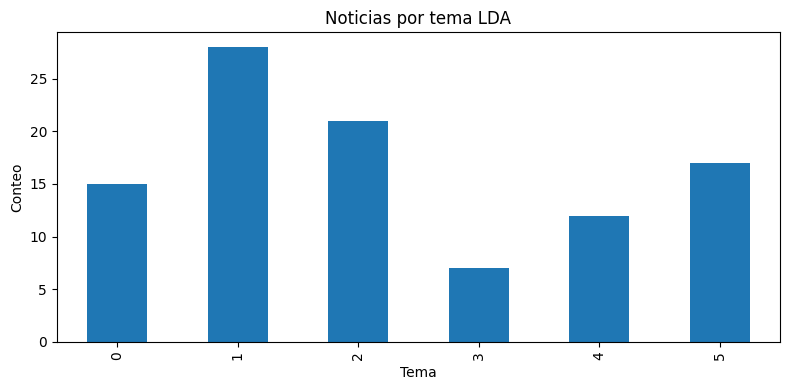

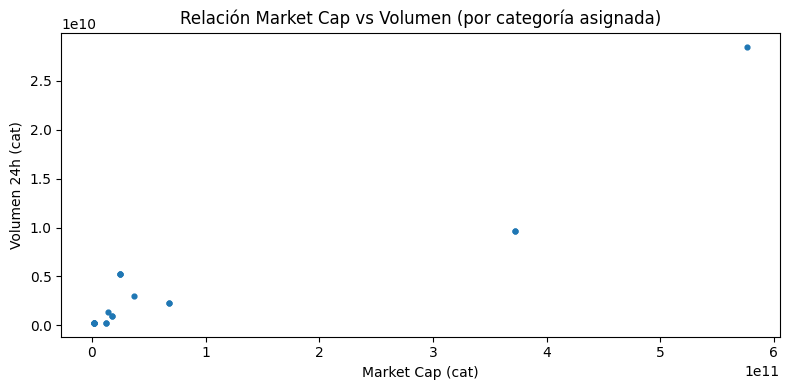

In [ ]:

sec("Gráficos de ejemplo")
if df_model is not None and not df_model.empty:
    # Conteo de noticias por tema
    if 'topic_idx' in df_model.columns:
        counts = df_model['topic_idx'].value_counts().sort_index()
        plt.figure()
        counts.plot(kind='bar')
        plt.title("Noticias por tema LDA")
        plt.xlabel("Tema"); plt.ylabel("Conteo")
        plt.tight_layout(); plt.show()

    # Relación market cap vs. volumen si existen
    if {'market_cap','volume_24h'}.issubset(df_model.columns):
        s = df_model.dropna(subset=['market_cap','volume_24h'])
        if not s.empty:
            plt.figure()
            plt.scatter(s['market_cap'], s['volume_24h'], s=12)
            plt.xlabel("Market Cap (cat)"); plt.ylabel("Volumen 24h (cat)")
            plt.title("Relación Market Cap vs Volumen (por categoría asignada)")
            plt.tight_layout(); plt.show()



## 10) Conclusiones (CRISP‑ML — Preparación de los Datos)
- **Razonamiento de FE**: se aplicaron transformaciones logarítmicas y ratios para reducir sesgos y mejorar interpretabilidad (*market_cap*, *total_volume*, *turnover_ratio*, *volatility_ratio*).
- **Selección**: filtros de varianza y correlación para evitar redundancia; **Chi²/ANOVA** condicionados a la disponibilidad de un objetivo (*sentiment*).
- **Extracción**: **LDA** (temas noticiosos) y **PCA** (componentes latentes numéricos) para compactar información.
- **Integración**: noticias → categoría aproximada por mención de token; categorías → métricas agregadas; mercados → señales cuantitativas.
- **Listo para la siguiente fase**: modelado de **tendencias** y detección de **temas dominantes** en tiempo (agregando por `fecha` y monitoreando cambios en `topic_idx` y métricas de mercado/categoría).



Gráficos ilustrativos


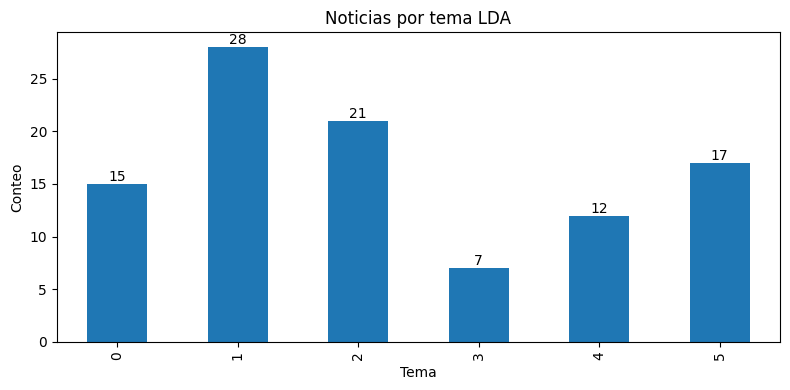

,topic_idx,keywords
0,0,"crypto, gold, treasury, bitcoin, million, teth..."
1,1,"bitcoin, crypto, new, stocks, btc, 000, octobe..."
2,2,"crypto, bitcoin, shutdown, 000, ethereum, mark..."
3,3,"intel, lending, key, defi, altcoins, token, fi..."
4,4,"coinbase, crypto, samsung, currency, app, digi..."
5,5,"return, open, 200, blank 200, 200 return, retu..."


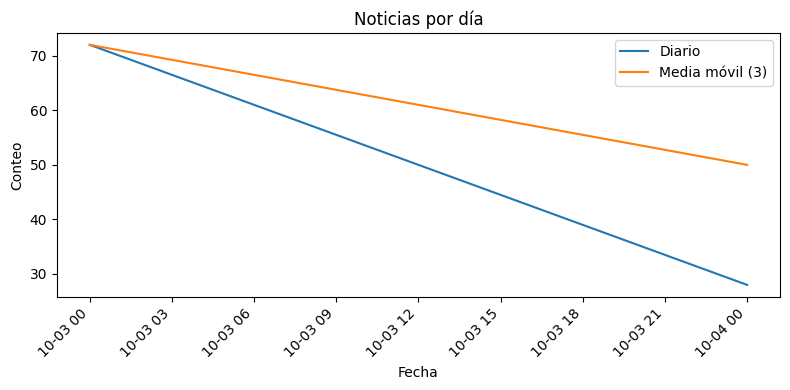

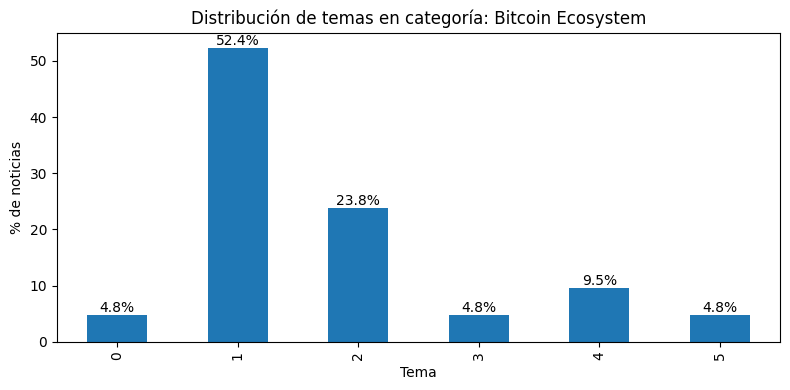

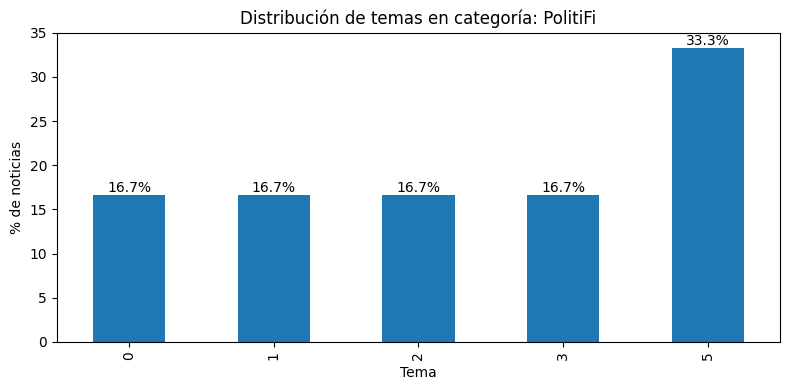

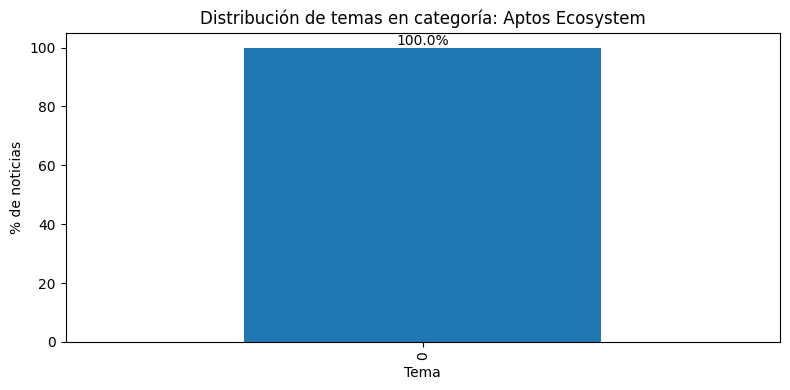

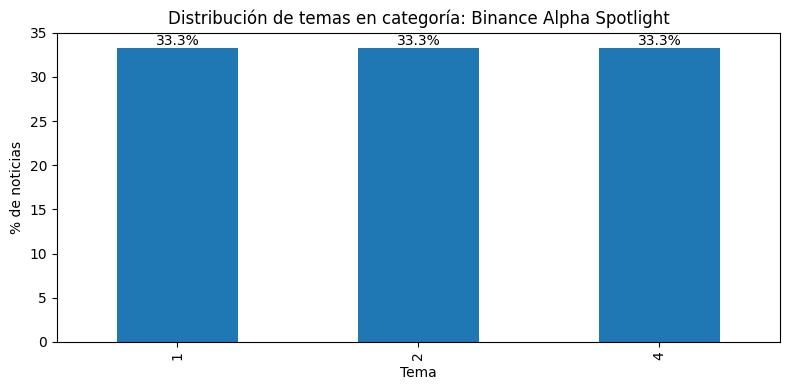

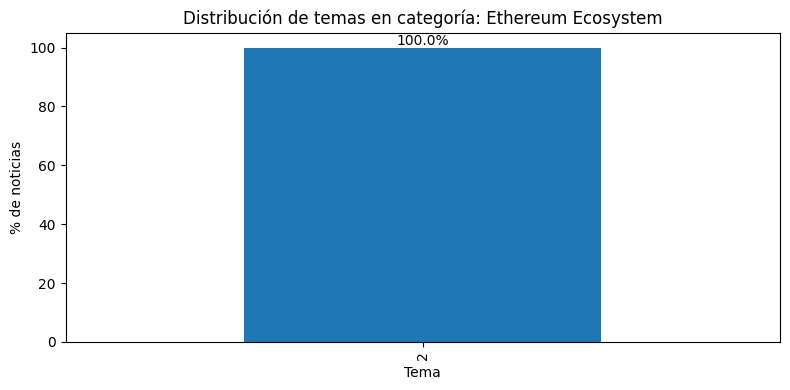

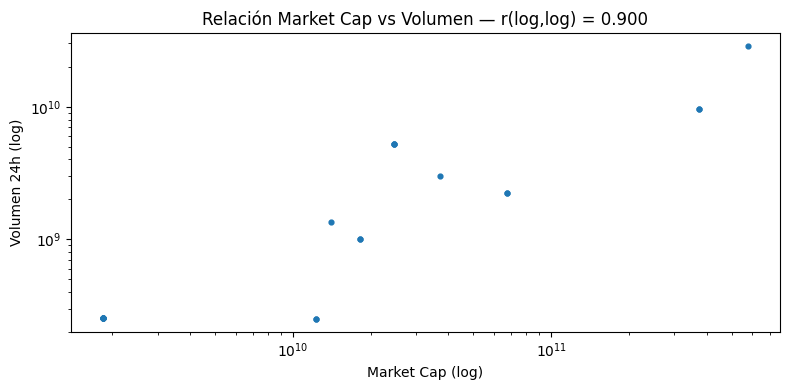

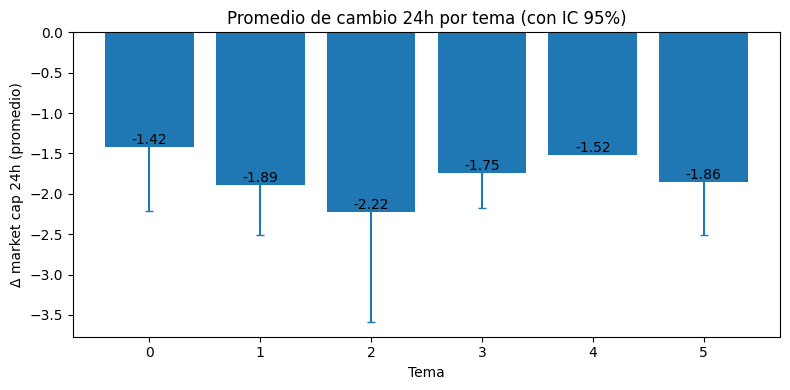

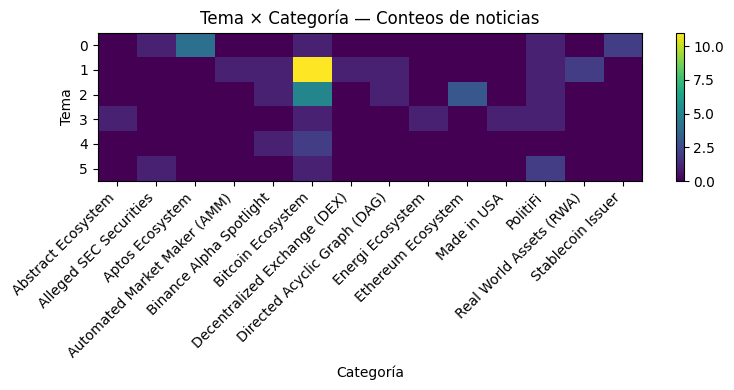

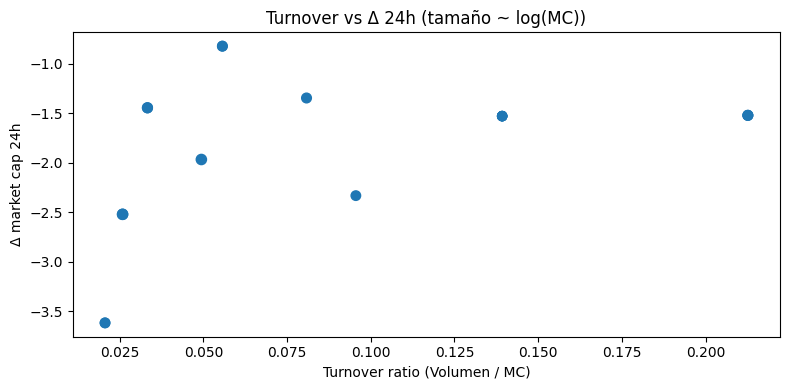

In [ ]:
# ============================================================
# Gráficos ilustrativos (sin seaborn, sin subplots, sin colors)
# ============================================================
try:
    sec
except NameError:
    def sec(t): print("\n" + "="*len(t) + f"\n{t}\n" + "="*len(t))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sec("Gráficos ilustrativos")

if df_model is None or df_model.empty:
    print("⚠️ df_model vacío o no definido.")
else:
    # -------- Helpers --------
    def _safe_to_datetime(s, dayfirst=True):
        try:
            return pd.to_datetime(s, dayfirst=dayfirst, errors='coerce')
        except Exception:
            return pd.to_datetime(pd.Series([None]))

    def _topic_label_map(df):
        """
        Devuelve un dict {topic_idx: 'palabras representativas'} tomando la moda
        (o la primera no nula) de topic_words por tema.
        """
        if not {"topic_idx","topic_words"}.issubset(df.columns):
            return {}
        tmp = (
            df.dropna(subset=["topic_idx"])
              .groupby("topic_idx")["topic_words"]
              .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else (x.dropna().iloc[0] if x.dropna().size else ""))
              .to_dict()
        )
        # Si está vacío, crear etiquetas simples
        if not tmp:
            for k in sorted(df["topic_idx"].dropna().unique()):
                tmp[int(k)] = f"Topic {int(k)}"
        return tmp

    # -------- 1) Conteo de noticias por tema + etiqueta de palabras --------
    if "topic_idx" in df_model.columns:
        counts = df_model["topic_idx"].value_counts().sort_index()
        topic_labels = _topic_label_map(df_model)
        plt.figure()
        counts.plot(kind="bar")
        plt.title("Noticias por tema LDA")
        plt.xlabel("Tema")
        plt.ylabel("Conteo")
        # Anotar valores y breve etiqueta (recortada)
        for i, v in enumerate(counts.values):
            plt.text(i, v, str(int(v)), ha="center", va="bottom")
        plt.tight_layout()
        plt.show()

        # Tabla auxiliar (opcional) de etiquetas para lectura rápida
        topic_table = pd.DataFrame({
            "topic_idx": counts.index.astype(int),
            "keywords": [topic_labels.get(int(k), "") for k in counts.index]
        })
        display(topic_table)

    # -------- 2) Tendencia diaria de noticias --------
    # Intenta obtener una fecha válida desde df_model['fecha'] (string dd/mm/YYYY)
    fecha_col = None
    for cand in ["fecha_dt", "fecha"]:
        if cand in df_model.columns:
            fecha_col = cand
            break

    if fecha_col is not None:
        dates = _safe_to_datetime(df_model[fecha_col], dayfirst=True)
        if dates.notna().any():
            tmp = pd.DataFrame({"fecha_dt": dates}).dropna()
            daily = tmp.groupby("fecha_dt").size().rename("news_count")
            # Serie con promedio móvil (si hay suficientes datos)
            rolling = daily.rolling(window=3, min_periods=1).mean()

            plt.figure()
            plt.plot(daily.index, daily.values, label="Diario")
            plt.plot(rolling.index, rolling.values, label="Media móvil (3)")
            plt.title("Noticias por día")
            plt.xlabel("Fecha"); plt.ylabel("Conteo")
            plt.legend()
            plt.xticks(rotation=45, ha="right")
            plt.tight_layout()
            plt.show()

    # -------- 3) Distribución de temas por categoría (Top-5 categorías) --------
    if {"primary_category_by_mention","topic_idx"}.issubset(df_model.columns):
        base = df_model.dropna(subset=["primary_category_by_mention","topic_idx"])
        if not base.empty:
            top_cats = (
                base["primary_category_by_mention"]
                .value_counts()
                .head(5)
                .index.tolist()
            )
            for cat_name in top_cats:
                sub = base.loc[base["primary_category_by_mention"] == cat_name]
                dist = (sub["topic_idx"].value_counts(normalize=True).sort_index() * 100.0)
                plt.figure()
                dist.plot(kind="bar")
                plt.title(f"Distribución de temas en categoría: {cat_name}")
                plt.xlabel("Tema"); plt.ylabel("% de noticias")
                for i, v in enumerate(dist.values):
                    plt.text(i, v, f"{v:.1f}%", ha="center", va="bottom")
                plt.tight_layout()
                plt.show()

    # -------- 4) Market Cap vs Volumen con escalas log + r (Pearson en log) --------
    if {"market_cap","volume_24h"}.issubset(df_model.columns):
        s = df_model.dropna(subset=["market_cap","volume_24h"])
        if not s.empty:
            x = s["market_cap"].astype(float)
            y = s["volume_24h"].astype(float)

            # Correlación en log10 para reducir sesgo de escala
            xlog = np.log10(np.clip(x, 1, None))
            ylog = np.log10(np.clip(y, 1, None))
            r = np.corrcoef(xlog, ylog)[0,1]

            plt.figure()
            plt.scatter(x, y, s=12)
            plt.xscale("log")
            plt.yscale("log")
            plt.xlabel("Market Cap (log)"); plt.ylabel("Volumen 24h (log)")
            plt.title(f"Relación Market Cap vs Volumen — r(log,log) = {r:.3f}")
            plt.tight_layout()
            plt.show()

    # -------- 5) Efecto promedio por tema: cambio 24h con IC 95% --------
    if {"topic_idx","market_cap_change_24h"}.issubset(df_model.columns):
        g = df_model.dropna(subset=["topic_idx","market_cap_change_24h"]).copy()
        if not g.empty:
            stats = (
                g.groupby("topic_idx")["market_cap_change_24h"]
                 .agg(["mean","count","std"])
                 .rename(columns={"mean":"mean_change","std":"sd","count":"n"})
                 .reset_index()
            )
            # Error estándar e IC 95%
            stats["se"] = stats["sd"] / np.sqrt(stats["n"]).replace(0, np.nan)
            stats["ci95"] = 1.96 * stats["se"]

            plt.figure()
            plt.bar(stats["topic_idx"].astype(str), stats["mean_change"])
            # error bars
            plt.errorbar(
                stats["topic_idx"].astype(str),
                stats["mean_change"],
                yerr=stats["ci95"],
                fmt='none',
                capsize=3
            )
            plt.title("Promedio de cambio 24h por tema (con IC 95%)")
            plt.xlabel("Tema"); plt.ylabel("Δ market cap 24h (promedio)")
            for i, v in enumerate(stats["mean_change"].values):
                plt.text(i, v, f"{v:+.2f}", ha="center", va="bottom")
            plt.tight_layout()
            plt.show()

    # -------- 6) Mapa (heatmap) de co-ocurrencia Tema × Categoría --------
    if {"topic_idx","primary_category_by_mention"}.issubset(df_model.columns):
        mat = (
            df_model.dropna(subset=["primary_category_by_mention","topic_idx"])
                    .groupby(["topic_idx","primary_category_by_mention"])
                    .size()
                    .unstack(fill_value=0)
        )
        if not mat.empty:
            plt.figure()
            plt.imshow(mat.values, aspect="auto")
            plt.title("Tema × Categoría — Conteos de noticias")
            plt.xlabel("Categoría"); plt.ylabel("Tema")
            plt.xticks(
                ticks=range(mat.shape[1]),
                labels=list(mat.columns),
                rotation=45, ha="right"
            )
            plt.yticks(
                ticks=range(mat.shape[0]),
                labels=list(mat.index)
            )
            plt.colorbar()
            plt.tight_layout()
            plt.show()

    # -------- 7) Señal de liquidez: turnover vs Δ 24h, tamaño ~ market cap --------
    # Si no existe turnover_ratio en df_model, lo calculamos al vuelo si hay volumen y MC.
    have_turnover = "turnover_ratio" in df_model.columns
    if not have_turnover and {"market_cap","volume_24h"}.issubset(df_model.columns):
        df_model = df_model.copy()
        with np.errstate(divide='ignore', invalid='ignore'):
            df_model["turnover_ratio"] = df_model["volume_24h"].astype(float) / df_model["market_cap"].astype(float)
        have_turnover = True

    if have_turnover and {"market_cap_change_24h","market_cap"}.issubset(df_model.columns):
        t = df_model.dropna(subset=["turnover_ratio","market_cap_change_24h","market_cap"])
        if not t.empty:
            size = np.log1p(t["market_cap"].astype(float)) * 2.0  # tamaño relativo (no color fijo)
            plt.figure()
            plt.scatter(t["turnover_ratio"], t["market_cap_change_24h"], s=size)
            plt.xlabel("Turnover ratio (Volumen / MC)"); plt.ylabel("Δ market cap 24h")
            plt.title("Turnover vs Δ 24h (tamaño ~ log(MC))")
            plt.tight_layout()
            plt.show()


/tmp/ipython-input-1737429210.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=counts.values, ax=ax, palette=palette)
/tmp/ipython-input-1737429210.py:48: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  sns.barplot(x=labels, y=counts.values, ax=ax, palette=palette)


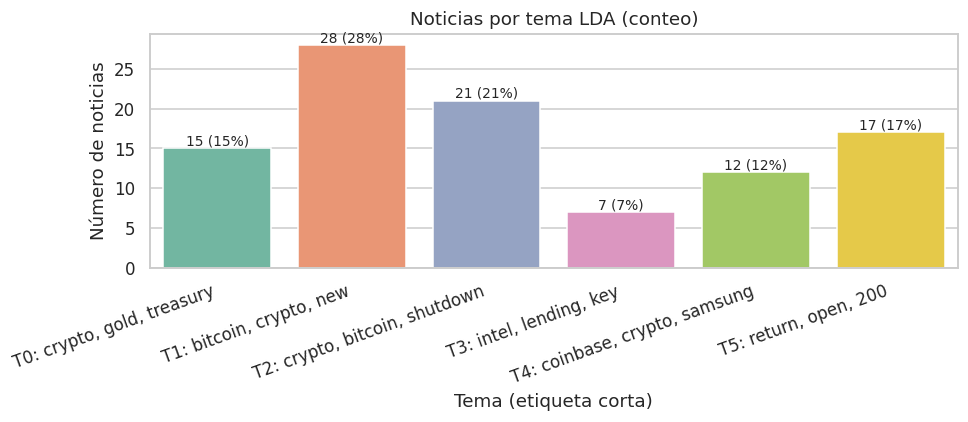

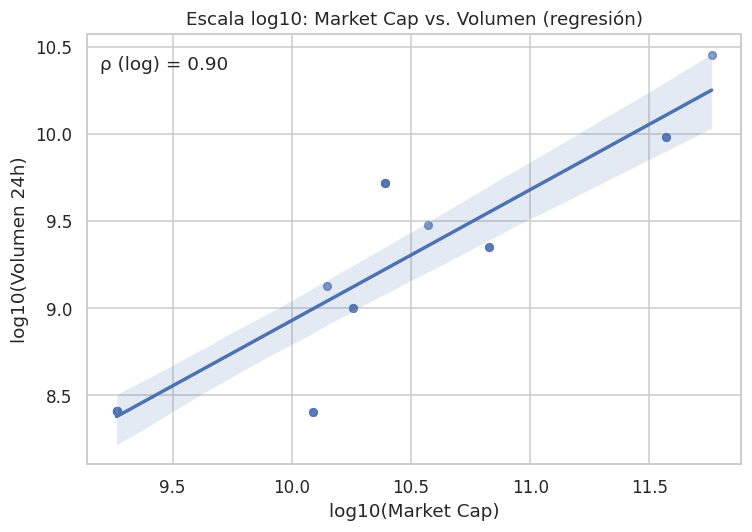

/tmp/ipython-input-1737429210.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='topic_idx', y='market_cap_change_24h', data=d, ax=ax, palette=palette, showfliers=False)
/tmp/ipython-input-1737429210.py:93: UserWarning: The palette list has more values (8) than needed (6), which may not be intended.
  sns.boxplot(x='topic_idx', y='market_cap_change_24h', data=d, ax=ax, palette=palette, showfliers=False)


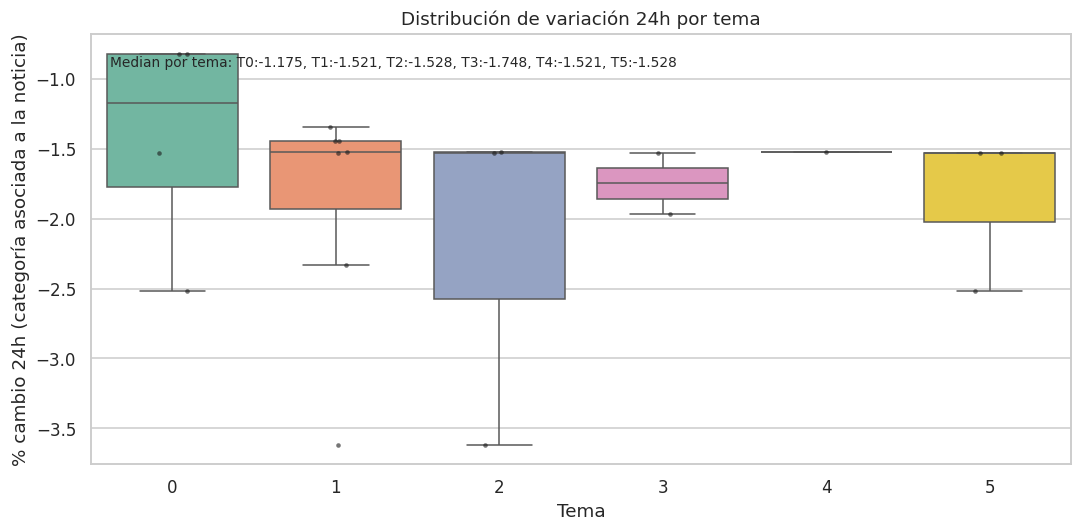

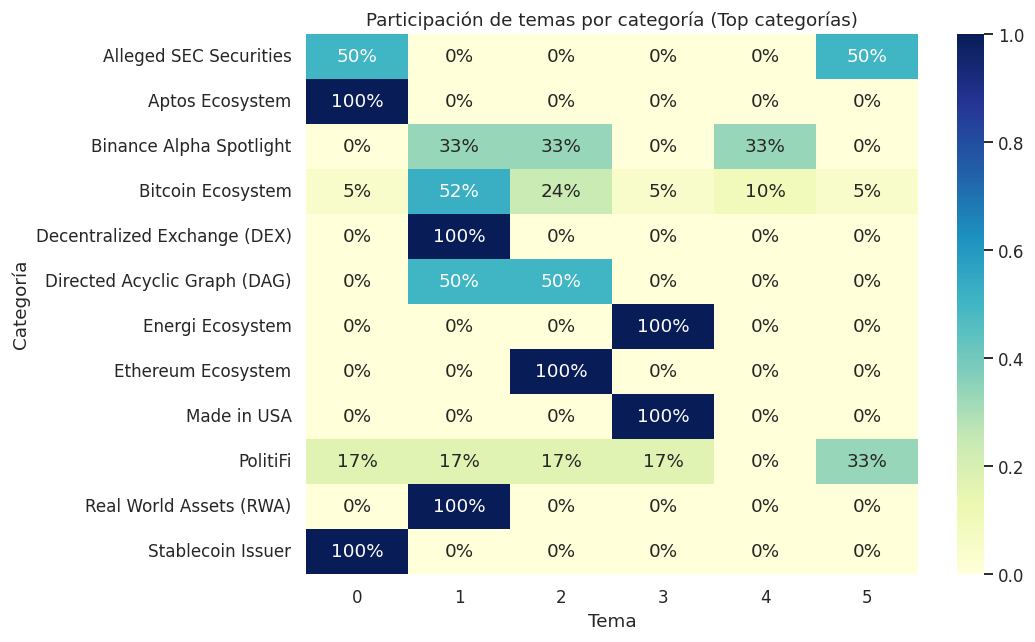

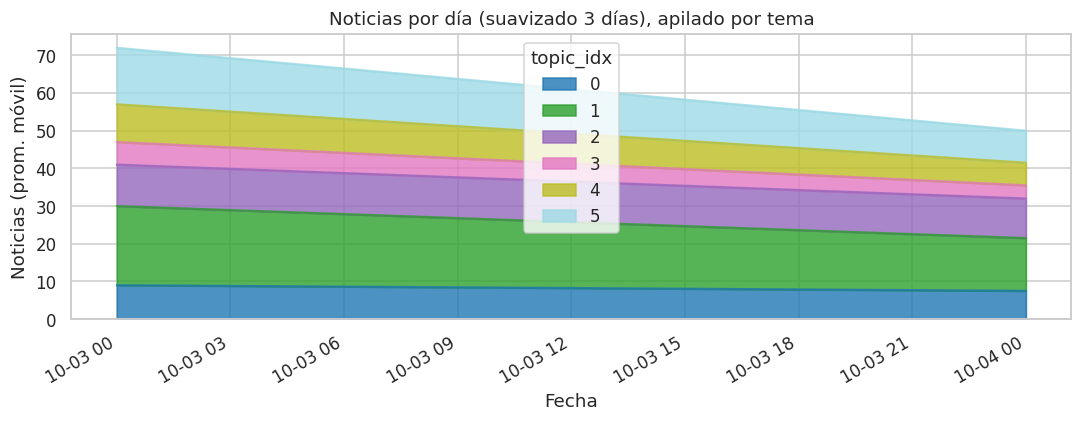

In [ ]:
# ================================
# Visualizaciones ilustrativas
# ================================
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
plt.rcParams["figure.dpi"] = 110

def _safe_datetime(s, dayfirst=True):
    try:
        return pd.to_datetime(s, dayfirst=dayfirst, errors="coerce")
    except Exception:
        return pd.to_datetime(pd.Series([], dtype=object))

assert 'df_model' in globals() and df_model is not None and not df_model.empty, "df_model no está disponible."

dfp = df_model.copy()

# Parseo de fecha si está disponible
if 'fecha' in dfp.columns:
    dfp['fecha_dt'] = _safe_datetime(dfp['fecha'])

# Etiquetas legibles para temas (usa las primeras 3 palabras del top_words)
if {'topic_idx','topic_words'}.issubset(dfp.columns):
    def short_label(s):
        s = str(s)
        words = [w for w in s.replace(',', ' ').split() if w.strip()]
        return ", ".join(words[:3]) if words else "topic"
    topic_labels = (dfp.groupby('topic_idx')['topic_words']
                      .first()
                      .fillna("topic")
                      .apply(short_label))
else:
    topic_labels = pd.Series(dtype=str)

palette = sns.color_palette("Set2")

# -----------------------------------------
# 1) Conteo de noticias por tema (barra)
# -----------------------------------------
if 'topic_idx' in dfp.columns:
    counts = dfp['topic_idx'].value_counts().sort_index()
    labels = [f"T{idx}: {topic_labels.get(idx, '')}" for idx in counts.index]
    fig, ax = plt.subplots(figsize=(9,4))
    sns.barplot(x=labels, y=counts.values, ax=ax, palette=palette)
    ax.set_title("Noticias por tema LDA (conteo)")
    ax.set_xlabel("Tema (etiqueta corta)")
    ax.set_ylabel("Número de noticias")
    # Anotaciones de porcentaje
    total = counts.sum()
    for i, v in enumerate(counts.values):
        ax.text(i, v, f"{v} ({v/total:.0%})", ha="center", va="bottom", fontsize=9)
    plt.xticks(rotation=20, ha="right")
    plt.tight_layout()
    plt.show()
else:
    print("ⓘ No se encontró 'topic_idx' para el gráfico de conteo por tema.")

# -------------------------------------------------------
# 2) Relación Market Cap vs Volumen (log-log + regresión)
# -------------------------------------------------------
if {'market_cap','volume_24h'}.issubset(dfp.columns):
    s = dfp[['market_cap','volume_24h']].dropna()
    if not s.empty and (s>0).all().all():
        s = s[(s['market_cap']>0) & (s['volume_24h']>0)].copy()
        s['log_mc']  = np.log10(s['market_cap'])
        s['log_vol'] = np.log10(s['volume_24h'])
        fig, ax = plt.subplots(figsize=(7,5))
        sns.regplot(x='log_mc', y='log_vol', data=s, ax=ax, scatter_kws=dict(s=25, alpha=0.7), line_kws=dict())
        ax.set_title("Escala log10: Market Cap vs. Volumen (regresión)")
        ax.set_xlabel("log10(Market Cap)")
        ax.set_ylabel("log10(Volumen 24h)")
        # Correlación (Pearson en log-espacio)
        corr = s[['log_mc','log_vol']].corr().iloc[0,1]
        ax.text(0.02, 0.95, f"ρ (log) = {corr:.2f}", transform=ax.transAxes, ha="left", va="top")
        plt.tight_layout()
        plt.show()
    else:
        print("ⓘ No hay datos positivos suficientes para el gráfico log-log de Market Cap vs Volumen.")
else:
    print("ⓘ Faltan columnas 'market_cap' y/o 'volume_24h'.")

# --------------------------------------------------------------------
# 3) Distribución de % cambio 24h por tema (caja + puntos individuales)
# --------------------------------------------------------------------
if {'market_cap_change_24h','topic_idx'}.issubset(dfp.columns):
    d = dfp[['market_cap_change_24h','topic_idx']].dropna()
    if not d.empty:
        fig, ax = plt.subplots(figsize=(10,5))
        sns.boxplot(x='topic_idx', y='market_cap_change_24h', data=d, ax=ax, palette=palette, showfliers=False)
        sns.stripplot(x='topic_idx', y='market_cap_change_24h', data=d, ax=ax, size=3, alpha=0.6, color='k')
        ax.set_title("Distribución de variación 24h por tema")
        ax.set_xlabel("Tema")
        ax.set_ylabel("% cambio 24h (categoría asociada a la noticia)")
        # Medianas por tema
        med = d.groupby('topic_idx')['market_cap_change_24h'].median().round(3)
        ax.text(0.02, 0.95, "Median por tema: " + ", ".join([f"T{t}:{v}" for t,v in med.items()]),
                transform=ax.transAxes, ha="left", va="top", fontsize=9)
        plt.tight_layout()
        plt.show()
    else:
        print("ⓘ No hay datos suficientes para la distribución de % cambio 24h por tema.")
else:
    print("ⓘ Faltan columnas para el boxplot por tema.")

# -------------------------------------------------------------
# 4) Mapa de calor: participación de temas por categoría (share)
# -------------------------------------------------------------
if {'primary_category_by_mention','topic_idx'}.issubset(dfp.columns):
    g = dfp.dropna(subset=['primary_category_by_mention','topic_idx'])
    if not g.empty:
        top_cats = (g['primary_category_by_mention'].value_counts().head(12).index.tolist())
        g2 = g[g['primary_category_by_mention'].isin(top_cats)].copy()
        # tabla de frecuencias normalizada por categoría
        tab = (g2
               .groupby(['primary_category_by_mention','topic_idx'])
               .size()
               .unstack(fill_value=0)
               .pipe(lambda x: x.div(x.sum(axis=1), axis=0))  # share por fila
              )
        fig, ax = plt.subplots(figsize=(10,6))
        sns.heatmap(tab.sort_index(), annot=True, fmt=".0%", cmap="YlGnBu", ax=ax)
        ax.set_title("Participación de temas por categoría (Top categorías)")
        ax.set_xlabel("Tema")
        ax.set_ylabel("Categoría")
        plt.tight_layout()
        plt.show()
    else:
        print("ⓘ No hay datos suficientes para el heatmap tema×categoría.")
else:
    print("ⓘ Faltan columnas para el heatmap de temas por categoría.")

# -----------------------------------------------
# 5) Tendencia temporal: noticias por día y tema
# -----------------------------------------------
if {'fecha_dt','topic_idx'}.issubset(dfp.columns):
    d = dfp.dropna(subset=['fecha_dt']).copy()
    if not d.empty:
        daily = (d.groupby(['fecha_dt','topic_idx'])
                   .size()
                   .rename('count')
                   .reset_index())
        # Pivot a formato ancho para apilado
        wide = daily.pivot(index='fecha_dt', columns='topic_idx', values='count').fillna(0)
        wide = wide.rolling(window=3, min_periods=1).mean()  # suavizado corto
        fig, ax = plt.subplots(figsize=(10,4))
        wide.plot.area(ax=ax, alpha=0.8, cmap="tab20")
        ax.set_title("Noticias por día (suavizado 3 días), apilado por tema")
        ax.set_xlabel("Fecha")
        ax.set_ylabel("Noticias (prom. móvil)")
        plt.tight_layout()
        plt.show()
    else:
        print("ⓘ No hay datos suficientes para la serie temporal de noticias por tema.")
else:
    print("ⓘ Faltan columnas para la serie temporal por tema.")
